<a href="https://colab.research.google.com/github/sispo3314/AI_study/blob/main/mHealth/mHealth_CBAM%2Btransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [383]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
from scipy import stats

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    BatchNormalization, Dropout, LayerNormalization, MultiHeadAttention,
    Add, Flatten
)

In [384]:
DATA_DIR = "/content/drive/MyDrive/datasets/MHEALTHDATASET"
COLS = [
    "chest_acc_x", "chest_acc_y", "chest_acc_z", "ecg_lead1", "ecg_lead2",
    "lankle_acc_x", "lankle_acc_y", "lankle_acc_z", "lankle_gyro_x",
    "lankle_gyro_y", "lankle_gyro_z", "lankle_mag_x", "lankle_mag_y",
    "lankle_mag_z", "rarm_acc_x", "rarm_acc_y", "rarm_acc_z",
    "rarm_gyro_x", "rarm_gyro_y", "rarm_gyro_z", "rarm_mag_x",
    "rarm_mag_y", "rarm_mag_z", "label"
]

In [385]:
ACTIVITY_MAP = {
    0: "null", 1: "standing", 2: "sitting", 3: "lying", 4: "walking",
    5: "climbing_stairs", 6: "waist_bends_forward", 7: "frontal_arm_raise",
    8: "knees_bending", 9: "cycling", 10: "jogging", 11: "running",
    12: "jump_front_back"
}
SAMPLING_RATE = 50

In [386]:
WINDOW_SECONDS = 2.5 # 2.5초 길이의 윈도우
WINDOW_SIZE = int(WINDOW_SECONDS * SAMPLING_RATE)
STEP = WINDOW_SIZE // 2

In [387]:
FEATURES_COLS = [c for c in COLS if c != "label"]
NUM_FEATURES = len(FEATURES_COLS)
NUM_CLASSES = 12

In [388]:
#데이터 로드 및 전처리
files=sorted(glob.glob(os.path.join(DATA_DIR, "mHealth_subject*.log")))

In [389]:
dfs=[]
for f in files:
    tmp = pd.read_csv(f, delim_whitespace=True, header=None)
    tmp.columns = COLS
    tmp["subject"] = int(re.search(r"subject(\d+)", f).group(1))
    dfs.append(tmp)

/tmp/ipython-input-3411836070.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipython-input-3411836070.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipython-input-3411836070.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipython-input-3411836070.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipython-input-3411836070.py:3: FutureWarning: T

In [390]:
df_raw=pd.concat(dfs, axis=0, ignore_index=True)
df_raw.shape

(1215745, 25)

In [391]:
#null (레이블 0) 데이터 제외
df_activity=df_raw[df_raw["label"]!=0].copy()
df_activity['label']=df_activity['label']-1

In [392]:
df_activity.shape

(343195, 25)

In [393]:
sorted(df_activity['label'].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11)]

In [394]:
#스케일링
#Train, test 분리 및 스케일링
train_subjects=[1, 2, 3, 4, 5, 6]
val_subjects=[7, 8]
test_subjects=[9, 10]

train_data=df_activity[df_activity['subject'].isin(train_subjects)].copy()
val_data=df_activity[df_activity['subject'].isin(val_subjects)].copy()
test_data=df_activity[df_activity['subject'].isin(test_subjects)].copy()

print(f"Train 데이터 shape: {train_data.shape} (Subjects: {train_subjects})")
print(f"Validation 데이터 shape: {val_data.shape} (Subjects: {val_subjects})")
print(f"Test 데이터 shape: {test_data.shape} (Subjects: {test_subjects})")

Train 데이터 shape: (207566, 25) (Subjects: [1, 2, 3, 4, 5, 6])
Validation 데이터 shape: (67585, 25) (Subjects: [7, 8])
Test 데이터 shape: (68044, 25) (Subjects: [9, 10])


In [395]:
#StandardScaler 적용
scaler=StandardScaler()
#scaler를 train data로만 fit 한다.
scaler.fit(train_data[FEATURES_COLS])

StandardScaler()

In [396]:
#스케일러 적용
train_data.loc[:, FEATURES_COLS] = scaler.transform(train_data[FEATURES_COLS])
val_data.loc[:, FEATURES_COLS] = scaler.transform(val_data[FEATURES_COLS])
test_data.loc[:, FEATURES_COLS] = scaler.transform(test_data[FEATURES_COLS])

In [397]:
#윈도우는 어떻게 잘라야할지?
def create_windows(data, window_size, step, features_cols, label_col='label'):
    X, y = [], []
    for subject, g in data.groupby('subject'):
        g = g.sort_index()
        segment = g[features_cols].values
        labels  = g[label_col].values
        n = len(g)
        for i in range(0, n - window_size + 1, step):
            win_y = labels[i : i + window_size]
            #최빈값을 라벨로
            win_label = stats.mode(win_y, keepdims=True)[0][0]
            X.append(segment[i : i + window_size])
            y.append(win_label)
    return np.array(X), np.array(y)

In [398]:
X_train, y_train = create_windows(train_data, WINDOW_SIZE, STEP, FEATURES_COLS)
X_val, y_val = create_windows(val_data, WINDOW_SIZE, STEP, FEATURES_COLS)
X_test, y_test = create_windows(test_data, WINDOW_SIZE, STEP, FEATURES_COLS)

print(f"X_train shape: {X_train.shape} | y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape} | y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape} | y_test shape: {y_test.shape}")

X_train shape: (3339, 125, 23) | y_train shape: (3339,)
X_val shape: (1087, 125, 23) | y_val shape: (1087,)
X_test shape: (1095, 125, 23) | y_test shape: (1095,)


### Transformer+CBAM

In [399]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    BatchNormalization, Dropout, LayerNormalization, MultiHeadAttention,
    Add, Flatten,
    GlobalMaxPooling1D, Multiply, Activation, Reshape, Permute,
    Lambda, Concatenate
)
from tensorflow.keras import backend as K
#케라스의 백엔드 함수를 K라는 별칭으로 import

In [400]:
def channel_attention(inputs, ratio=8):
  #K.int_shape: 입력받은 텐서(tensor)의 shape를 파이썬 정수 튜플로 반환
  channels=K.int_shape(inputs)[-1] #반환된 튜플의 마지막 요소 (channels)가져오기
  #MLP 공유
  shared_layer_one=Dense(channels//ratio, activation='relu',
                         kernel_initializer='he_normal', use_bias=True)
  shared_layer_two=Dense(channels, kernel_initializer='he_normal', use_bias=True)

  #Global Average Pooling
  avg_pool=GlobalAveragePooling1D()(inputs) #(batch, channels)
  avg_pool=shared_layer_one(avg_pool)
  avg_pool=shared_layer_two(avg_pool)

  #Global Max Pooling
  max_pool=GlobalMaxPooling1D()(inputs) #(batch, channels)
  max_pool=shared_layer_one(max_pool)
  max_pool=shared_layer_two(max_pool)

  attention=Add()([avg_pool, max_pool])
  attention=Activation('sigmoid')(attention)

  #Reshape
  attention=Reshape((1, channels))(attention)
  return Multiply()([inputs, attention])


In [401]:

def spatial_attention(inputs, kernel_size=7):
  #채널 축 압축 (각 seq_len(시간)마다 존재하는 여러 채널의 정보를 하나의 대표값으로 요약)
  #inputs: 연산을 적용할 대상 텐서, axis=2: 압축할 차원의 번호(=channels), keepdims=True: 차원을 유지하라.)
  avg_pool=Lambda(lambda x: tf.reduce_mean(x, axis=2, keepdims=True))(inputs) # (batch, seq_len, 1)
  max_pool=Lambda(lambda x: tf.reduce_max(x, axis=2, keepdims=True))(inputs) # (batch, seq_len, 1)

  #요약 정보 합치기
  concat=Concatenate(axis=2)([avg_pool, max_pool]) # (batch, seq_len, 2)

  #1D 컨볼루션 적용(중요도 점수 계산)
  #sigmoid 활성함수를 사용하여 0과 1 사이의 점수로 변환
  attention=Conv1D(1,
                   kernel_size, padding='same',
                   activation='sigmoid', kernel_initializer='he_normal',
                   use_bias=False)(concat) #(batch, seq_len, 1)
  #원본 입력에 중요도 점수맵 곱하기
  return Multiply()([inputs, attention])

In [402]:
#CBAM 블록
def cbam_block(inputs, ratio=8, kernel_size=7):
  cbam_feature=channel_attention(inputs, ratio)
  cbam_feature=spatial_attention(cbam_feature, kernel_size)
  return cbam_feature

In [403]:
from tensorflow.keras.layers import Embedding, Layer

class PositionalEmbedding(Layer):
    def __init__(self, seq_len, d_model, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.pos_emb = Embedding(input_dim=seq_len, output_dim=d_model)
        self.seq_len = seq_len

    def call(self, x):
        positions = tf.range(start=0, limit=self.seq_len, delta=1)
        embedded_positions = self.pos_emb(positions)
        return x + embedded_positions

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            'seq_len': self.seq_len,
            'd_model': self.d_model,
        })
        return config

In [404]:
def transformer_encoder_block(inputs, d_model, num_heads, ff_dim, dropout=0.1):
  #멀티헤드 어텐션
  attn_input=LayerNormalization(epsilon=1e-6)(inputs)
  attention=MultiHeadAttention(
      num_heads=num_heads, key_dim=d_model//num_heads
  )(attn_input, attn_input)
  attention=Dropout(dropout)(attention)
  attn_output=Add()([inputs, attention])

  #피드포워드 네트워크
  ffn_input=LayerNormalization(epsilon=1e-6)(attn_output)
  ffn_output=Dense(ff_dim, activation="relu")(ffn_input)
  ffn_output=Dropout(dropout)(ffn_output)
  ffn_output=Dense(d_model)(ffn_output)

  return Add()([attn_output, ffn_output])

In [405]:
#모델 빌드 함수
def build_cbam_transformer(input_shape, num_classes, d_model, num_heads=4,
                           ff_dim=128, num_transformer_blocks=2):
  inputs=Input(shape=input_shape)

  x=Conv1D(filters=32, kernel_size=5, activation='relu', padding="same")(inputs)
  x=BatchNormalization()(x)
  x=cbam_block(x, ratio=4)
  x=MaxPooling1D(pool_size=2)(x)

  x=Conv1D(filters=d_model, kernel_size=5, activation='relu', padding="same")(x)
  x=BatchNormalization()(x)
  x=cbam_block(x, ratio=8)
  x=MaxPooling1D(pool_size=2)(x)

  #트랜스포머
  x=PositionalEmbedding(seq_len=x.shape[1], d_model=d_model)(x)
  x=Dropout(0.1)(x)

  for _ in range(num_transformer_blocks):
    x=transformer_encoder_block(x, d_model, num_heads, ff_dim)

  x=GlobalAveragePooling1D()(x)
  x=Dropout(0.5)(x)
  x=Dense(64, activation='relu')(x)
  x=Dropout(0.5)(x)
  outputs=Dense(num_classes, activation='softmax')(x)

  model=Model(inputs=inputs, outputs=outputs)
  return model

In [406]:
model_inputs_shape=(WINDOW_SIZE, NUM_FEATURES)

cbam_transformer_model=build_cbam_transformer(
    model_inputs_shape,
    num_classes=NUM_CLASSES,
    d_model=64, num_heads=4,
    ff_dim=128, num_transformer_blocks=1
)

cbam_transformer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbam_transformer_model.summary()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 125, 23)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_131 (Conv1D) │ (None, 125, 32)   │      3,712 │ input_layer_34[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 32)   │        128 │ conv1d_131[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_272 (Dense)   │ (None, 8)         │        264 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_273 (Dense)   │ (None, 32)        │        288 │ dense_272[0][0],  │
│                     │                   │            │ dense_272[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_142 (Add)       │ (None, 32)        │          0 │ dense_273[0][0],  │
│                     │                   │            │ dense_273[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 32)        │          0 │ add_142[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_66          │ (None, 1, 32)     │          0 │ activation_66[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_131        │ (None, 125, 32)   │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ reshape_66[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_126 (Lambda) │ (None, 125, 1)    │          0 │ multiply_131[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_127 (Lambda) │ (None, 125, 1)    │          0 │ multiply_131[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_61      │ (None, 125, 2)    │          0 │ lambda_126[0][0], │
│ (Concatenate)       │                   │            │ lambda_127[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_132 (Conv1D) │ (None, 125, 1)    │         14 │ concatenate_61[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_132        │ (None, 125, 32)   │          0 │ multiply_131[0][… │
│ (Multiply)          │                   │            │ conv1d_132[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_65    │ (None, 62, 32)    │          0 │ multiply_132[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_133 (Conv1D) │ (None, 62, 64)    │     10,304 │ max_pooling1d_65… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 56,472 (220.59 KB)

 Trainable params: 56,280 (219.84 KB)

 Non-trainable params: 192 (768.00 B)

In [407]:
import tensorflow as tf
tf.keras.utils.plot_model(cbam_transformer_model, show_shapes=True)

In [408]:
from sklearn.utils import class_weight

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6
    )
]

weights=class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict=dict(enumerate(weights))

history_cbam = cbam_transformer_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - accuracy: 0.3447 - loss: 1.9583 - val_accuracy: 0.2603 - val_loss: 2.1844 - learning_rate: 0.0010
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7661 - loss: 0.6760 - val_accuracy: 0.6182 - val_loss: 1.3408 - learning_rate: 0.0010
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8826 - loss: 0.3312 - val_accuracy: 0.6863 - val_loss: 1.1382 - learning_rate: 0.0010
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9146 - loss: 0.2422 - val_accuracy: 0.8436 - val_loss: 0.9032 - learning_rate: 0.0010
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9552 - loss: 0.1361 - val_accuracy: 0.8316 - val_loss: 0.7056 - learning_rate: 0.0010
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9672 - loss: 0.1267 - val_accuracy: 0.8703 - val_loss: 0.7207 - learning_rate: 0.0010
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9666 - loss: 0.1064

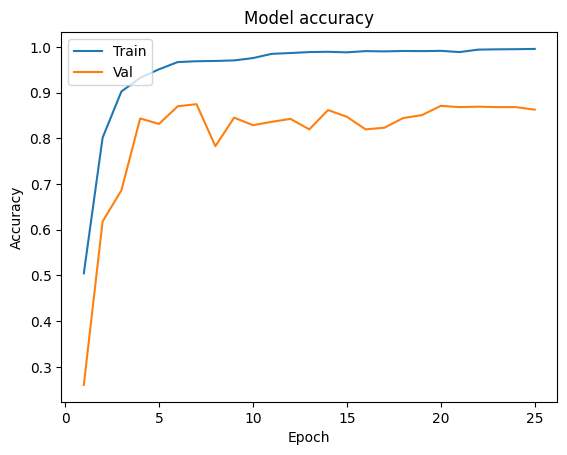

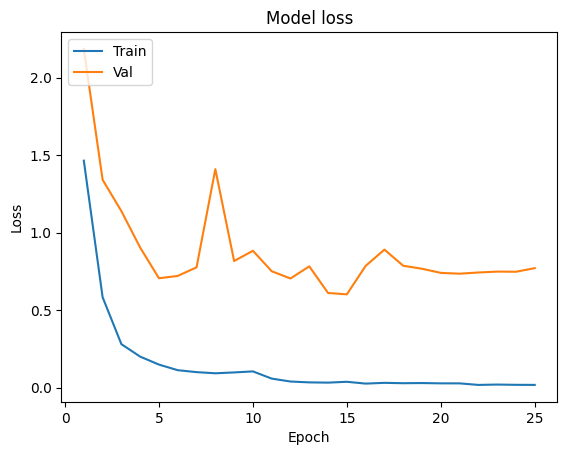

In [409]:
import matplotlib.pyplot as plt
def plot_learningCurve(history_cbam, epochs):
  # Plot training & validation accuracy values
  epochs_run = len(history_cbam.history['loss'])
  epoch_range = range(1, epochs_run+1)
  plt.plot(epoch_range, history_cbam.history['accuracy'])
  plt.plot(epoch_range, history_cbam.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history_cbam.history['loss'])
  plt.plot(epoch_range, history_cbam.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
plot_learningCurve(history_cbam, 50)

In [410]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [411]:
# 2. Classification Report
y_pred_cbam = cbam_transformer_model.predict(X_test)
y_pred_classes_cbam = np.argmax(y_pred_cbam, axis=1)
target_names = [v for k, v in ACTIVITY_MAP.items() if k != 0]
print("\n--- Classification Report (CBAM Model) ---")
print(classification_report(y_test, y_pred_classes_cbam, target_names=target_names))

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step

--- Classification Report (CBAM Model) ---
                     precision    recall  f1-score   support

           standing       1.00      1.00      1.00        99
            sitting       0.98      0.99      0.98        99
              lying       1.00      1.00      1.00        99
            walking       0.98      0.64      0.77        99
    climbing_stairs       0.67      1.00      0.80        98
waist_bends_forward       0.94      0.99      0.97        86
  frontal_arm_raise       0.99      0.84      0.91        90
      knees_bending       1.00      0.92      0.96        95
            cycling       0.98      1.00      0.99        99
            jogging       1.00      1.00      1.00        99
            running       1.00      1.00      1.00        99
    jump_front_back       1.00      1.00      1.00        33

           accuracy                           0.95      1095
          macro avg       0.96      0.95      0.95      1095


--- Confusion Matrix (CBAM Model) ---


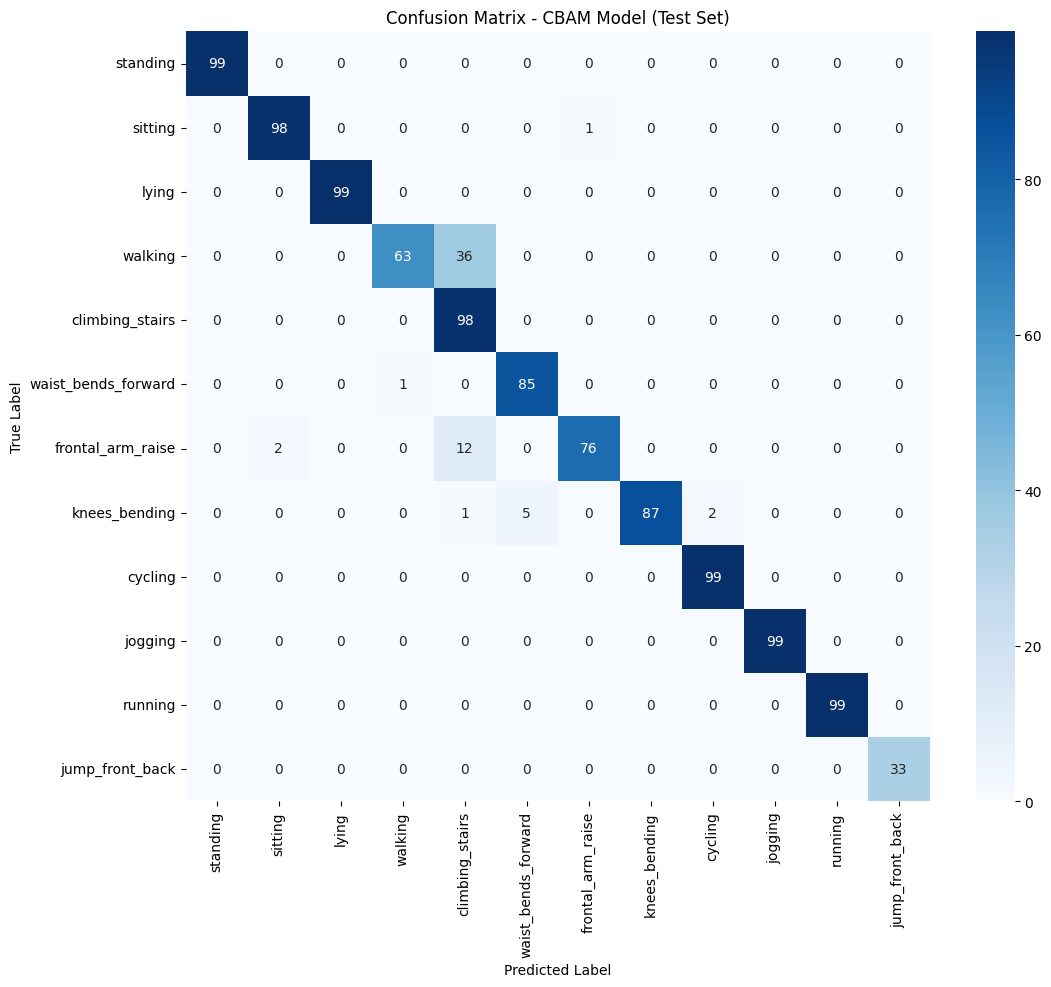

In [412]:
print("\n--- Confusion Matrix (CBAM Model) ---")
cm_cbam = confusion_matrix(y_test, y_pred_classes_cbam)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_cbam, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - CBAM Model (Test Set)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()